In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np

import sys 
sys.path.append("../..") 
import os
%aimport preprocessing
%aimport utils
%aimport p2v

from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
from collections import defaultdict

from utils import prinT

import seaborn as sns
from matplotlib import pyplot as plt

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)

In [3]:
model = p2v.P2V()
d=100
w=10

2024-11-08 10:04:30 -- start loading Mag_venue_info_df
2024-11-08 10:04:30 -- finish.
2024-11-08 10:04:30 -- start loading labeled_journal_info_df
2024-11-08 10:04:30 -- finish.


## tracking Cognitive Science

Cognitive Science
78735424

In [ ]:
def default_value():
    return 0


def count_paper_num_for_subarea(VID, percentage: bool=False, collapse_into_others: int=20):
    dict_list = []
    for i in range(len(model.start_year_list)-5, len(model.start_year_list)):
        start_year=model.start_year_list[i]
        end_year=model.end_year_list[i]
        prinT("start searching in %s to %s" %(start_year, end_year))

        model.load_paper_df(full_load=False, start_year=start_year, end_year=end_year)
        model.load_ref_df(full_load=False, start_year=start_year, end_year=end_year)
        VID_labeled = model.load_VID_labeled(start_year, end_year, d, w)
        VID_labeled_df = pd.DataFrame(VID_labeled)
        VID_labeled_df.set_index('VID', inplace=True)

        journal_df = model.target_paper_df[model.target_paper_df.VenueID == VID]
        journal_ref_df = pd.merge(journal_df, model.target_ref_df, left_on='PaperID', right_on='PaperID')
        journal_ref_df = pd.merge(journal_ref_df, model.target_paper_df, left_on='PaperReferenceID', right_on='PaperID')
        journal_ref_df.drop(columns=['PaperReferenceID'], inplace=True)
        journal_ref_df = pd.merge(journal_ref_df, VID_labeled_df, left_on='VenueID_y', right_index=True)

        journal_ref_df.drop(journal_ref_df[
                            (journal_ref_df['subarea_label'].str.contains('General'))|
                            (journal_ref_df['subarea_label'].str.contains('miscellaneous'))|
                            (journal_ref_df['subarea_label']=='Multidisciplinary')].index, 
                            inplace=True)

        subarea_paper_count = defaultdict(default_value)
        for row in journal_ref_df.groupby(['PaperID_x'])['subarea_label'].agg(pd.Series.mode):
            if type(row) == str:
                subarea_paper_count[row] = subarea_paper_count[row] + 1
            if type(row) == np.ndarray:
                subarea_num = len(row)
                for subarea in row:
                    subarea_paper_count[subarea] = subarea_paper_count[subarea] + 1/subarea_num
        dict_list.append(dict(subarea_paper_count))
    count_df = pd.DataFrame(dict_list).T
    count_df.columns = ['1970s', '1980s', '1990s', '2000s', '2010s']
    count_df['sum']=count_df.sum(axis=1)

    if collapse_into_others != 0:
        count_df.reset_index(inplace=True)
        count_df = count_df.sort_values("sum", ascending=False)
        count_df_up = count_df.iloc[:collapse_into_others]
        count_df_full = pd.concat([count_df_up, pd.DataFrame({'index': 'others', 
                                                            '1970s': count_df['1970s'].iloc[10:].sum(), 
                                                            '1980s': count_df['1980s'].iloc[10:].sum(), 
                                                            '1990s': count_df['1990s'].iloc[10:].sum(), 
                                                            '2000s': count_df['2000s'].iloc[10:].sum(), 
                                                            '2010s': count_df['2010s'].iloc[10:].sum(), 
                                                            'sum': count_df['sum'].iloc[7:].sum()}, 
                                                            index=[0])], 
                                ignore_index=True)
        count_df_full.set_index('index', inplace=True)
    else:
        count_df_full = count_df


    if percentage:
        count_df_full['1970s'] = (count_df_full['1970s']/count_df_full['1970s'].sum()) * 100
        count_df_full['1980s'] = (count_df_full['1980s']/count_df_full['1980s'].sum()) * 100
        count_df_full['1990s'] = (count_df_full['1990s']/count_df_full['1990s'].sum()) * 100
        count_df_full['2000s'] = (count_df_full['2000s']/count_df_full['2000s'].sum()) * 100
        count_df_full['2010s'] = (count_df_full['2010s']/count_df_full['2010s'].sum()) * 100

    count_df_full.index.rename('decade', inplace=True)
    count_df_full.drop('sum', axis=1, inplace=True)

    return count_df_full.T


def cal_subarea_avg_cs(target_VID: int):
    cs_data = []
    for i in range(len(model.start_year_list)-5, len(model.start_year_list)):
        model.load_wv(model.start_year_list[i], model.end_year_list[i], d, w)
        target_journal_vector = model.wv.get_vector(target_VID, norm=True)

        VID_labeled = model.load_VID_labeled(model.start_year_list[i], model.end_year_list[i], d, w)
        label_list = VID_labeled['subarea_label']
        labeled_VID_list = VID_labeled['VID']
        labeled_vector_list = np.stack([model.wv.get_vector(VID, norm=True) for VID in labeled_VID_list])

        single_decade_data = {}
        subareas = list(set(label_list))
        for subarea in subareas:
            single_subarea_idx_list = [idx for idx, label in list(enumerate(label_list)) if label == subarea]
            single_subarea_cs = cosine_similarity(target_journal_vector.reshape(1, -1), labeled_vector_list[single_subarea_idx_list])
            
            single_decade_data[subarea] = np.mean((single_subarea_cs))
        cs_data.append(single_decade_data)
    cs_df = pd.DataFrame(cs_data).T
    cs_df.columns = ['1970s', '1980s', '1990s', '2000s', '2010s']
    cs_df['sum']=cs_df.sum(axis=1)
    cs_df = cs_df.sort_values("sum", ascending=False)
    cs_df.index.rename('decade', inplace=True)
    cs_df.drop('sum', axis=1, inplace=True)

    return cs_df.T

def cal_subarea_all_cs(target_VID: int):
    start_year_list = model.start_year_list[-5:]
    end_year_list = model.end_year_list[-5:]

    cs_df = pd.DataFrame(columns=['VID', 'similarity', 'decade', 'subarea'])
    for start_year, end_year in zip(start_year_list, end_year_list):
        model.load_wv(start_year, end_year, 100, 10)
        target_journal_vector = model.wv.get_vector(target_VID, norm=True)
        VID_labeled = model.load_VID_labeled(start_year, end_year, 100, 10)
        labeled_vector_list = np.stack([model.wv.get_vector(VID, norm=True) for VID in VID_labeled['VID']])

        label_list = VID_labeled['subarea_label']
        subareas = list(set(label_list))
        for subarea in subareas:
            single_subarea_idx_list = [idx for idx, label in list(enumerate(VID_labeled['subarea_label'])) if label == subarea]
            single_subarea_cs = cosine_similarity(target_journal_vector.reshape(1, -1), 
                                                  labeled_vector_list[single_subarea_idx_list])
            for idx, cs_value in enumerate(single_subarea_cs[0]):
                new_row = {
                    'VID': VID_labeled['VID'][single_subarea_idx_list[idx]],
                    'similarity': cs_value,
                    'decade': f"{start_year}s",
                    'subarea': subarea
                }
                cs_df = pd.concat([cs_df, pd.DataFrame([new_row])], ignore_index=True)
    return cs_df

def cal_jnl_cs(center_vname: str, venue_name_list: list):
    center_VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==center_vname].index[0]
    jnl_cs_df = pd.DataFrame(columns=venue_name_list)
    
    for i, start_year in enumerate(start_year_list):
        end_year = end_year_list[i]
        wv = model.load_wv(start_year, end_year, d, w)
        
        for venue_name in venue_name_list:
            VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==venue_name].index[0]
            try:
                sim = wv.similarity(center_VID, VID)
                jnl_cs_df.loc[str(start_year)+'s', venue_name] = sim
            except KeyError:
                jnl_cs_df.loc[str(start_year)+'s', venue_name] = np.nan
    return jnl_cs_df

In [5]:
count_df = count_paper_num_for_subarea(78735424, collapse_into_others=20)

2024-11-08 10:06:49 -- start searching in 1970 to 1979
2024-11-08 10:06:49 -- start loading 'paper_df'...
2024-11-08 10:06:49 -- finish.
2024-11-08 10:06:49 -- start loading 'ref_df'...
2024-11-08 10:06:49 -- finish.
2024-11-08 10:06:49 -- start loading VID_labeled...
2024-11-08 10:06:49 -- finish.
2024-11-08 10:06:50 -- start searching in 1980 to 1989
2024-11-08 10:06:50 -- start loading 'paper_df'...
2024-11-08 10:06:50 -- finish.
2024-11-08 10:06:50 -- start loading 'ref_df'...
2024-11-08 10:06:50 -- finish.
2024-11-08 10:06:50 -- start loading VID_labeled...
2024-11-08 10:06:50 -- finish.
2024-11-08 10:06:52 -- start searching in 1990 to 1999
2024-11-08 10:06:52 -- start loading 'paper_df'...
2024-11-08 10:06:52 -- finish.
2024-11-08 10:06:52 -- start loading 'ref_df'...
2024-11-08 10:06:52 -- finish.
2024-11-08 10:06:52 -- start loading VID_labeled...
2024-11-08 10:06:52 -- finish.
2024-11-08 10:06:54 -- start searching in 2000 to 2009
2024-11-08 10:06:54 -- start loading 'paper_d

In [6]:
count_df

decade,Experimental and Cognitive Psychology,Linguistics and Language,Developmental and Educational Psychology,Artificial Intelligence,Cognitive Neuroscience,Education,Philosophy,Social Psychology,Sensory Systems,Neuropsychology and Physiological Psychology,Human-Computer Interaction,Economics and Econometrics,Statistics and Probability,Marketing,Neurology,Psychiatry and Mental Health,Molecular Biology,Neurology (clinical),Behavioral Neuroscience,Strategy and Management,others
1970s,3.750000,16.250000,NaN,11.916667,NaN,1.833333,1.583333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.666667
1980s,24.250000,27.416667,1.250000,61.666667,NaN,6.083333,5.833333,0.500000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,2.500000,NaN,12.000000
1990s,43.750000,18.750000,2.250000,57.833333,4.000000,12.500000,4.333333,0.500000,NaN,1.000000,4.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,4.083333,2.0,17.083333
2000s,229.366667,46.450000,18.333333,7.533333,14.500000,11.000000,7.866667,4.833333,3.500000,6.700000,1.833333,1.000000,1.200000,1.250000,NaN,2.0,NaN,1.000000,0.500000,NaN,32.916667
2010s,2560.433333,389.466667,279.483333,57.950000,146.183333,127.266667,98.916667,77.266667,45.033333,35.033333,28.250000,22.233333,20.033333,18.666667,17.033333,15.0,16.333333,13.833333,7.533333,9.5,374.966667


In [66]:
all_cs_df = cal_subarea_all_cs(78735424)

2024-11-08 11:39:33 -- start loading word vectors...
2024-11-08 11:39:33 -- word vectors loaded, and its shape is: (5686, 100)
2024-11-08 11:39:33 -- start loading VID_labeled...
2024-11-08 11:39:33 -- finish.


C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_9584\2643175669.py:125: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cs_df = pd.concat([cs_df, pd.DataFrame([new_row])], ignore_index=True)


2024-11-08 11:39:35 -- start loading word vectors...
2024-11-08 11:39:35 -- word vectors loaded, and its shape is: (9337, 100)
2024-11-08 11:39:35 -- start loading VID_labeled...
2024-11-08 11:39:35 -- finish.
2024-11-08 11:39:37 -- start loading word vectors...
2024-11-08 11:39:37 -- word vectors loaded, and its shape is: (15019, 100)
2024-11-08 11:39:37 -- start loading VID_labeled...
2024-11-08 11:39:37 -- finish.
2024-11-08 11:39:42 -- start loading word vectors...
2024-11-08 11:39:42 -- word vectors loaded, and its shape is: (27460, 100)
2024-11-08 11:39:42 -- start loading VID_labeled...
2024-11-08 11:39:42 -- finish.
2024-11-08 11:39:53 -- start loading word vectors...
2024-11-08 11:39:53 -- word vectors loaded, and its shape is: (37594, 100)
2024-11-08 11:39:53 -- start loading VID_labeled...
2024-11-08 11:39:53 -- finish.


In [56]:
cs_df = cal_subarea_avg_cs(78735424)

2024-11-08 11:28:50 -- start loading word vectors...
2024-11-08 11:28:50 -- word vectors loaded, and its shape is: (5686, 100)
2024-11-08 11:28:50 -- start loading VID_labeled...
2024-11-08 11:28:50 -- finish.
2024-11-08 11:28:51 -- start loading word vectors...
2024-11-08 11:28:51 -- word vectors loaded, and its shape is: (9337, 100)
2024-11-08 11:28:51 -- start loading VID_labeled...
2024-11-08 11:28:51 -- finish.
2024-11-08 11:28:52 -- start loading word vectors...
2024-11-08 11:28:52 -- word vectors loaded, and its shape is: (15019, 100)
2024-11-08 11:28:52 -- start loading VID_labeled...
2024-11-08 11:28:52 -- finish.
2024-11-08 11:28:53 -- start loading word vectors...
2024-11-08 11:28:53 -- word vectors loaded, and its shape is: (27460, 100)
2024-11-08 11:28:53 -- start loading VID_labeled...
2024-11-08 11:28:53 -- finish.
2024-11-08 11:28:56 -- start loading word vectors...
2024-11-08 11:28:56 -- word vectors loaded, and its shape is: (37594, 100)
2024-11-08 11:28:56 -- start l

In [57]:
cs_df

decade,Experimental and Cognitive Psychology,Linguistics and Language,Artificial Intelligence,Language and Linguistics,Psychology (miscellaneous),Philosophy,General Psychology,Music,Social Psychology,Education,Developmental and Educational Psychology,Information Systems,Computational Theory and Mathematics,Computer Graphics and Computer-Aided Design,Software,Logic,Neuropsychology and Physiological Psychology,Control and Optimization,Human-Computer Interaction,Human Factors and Ergonomics,Communication,Cognitive Neuroscience,General Computer Science,Library and Information Sciences,Literature and Literary Theory,Computer Science Applications,Applied Psychology,Theoretical Computer Science,Classics,Speech and Hearing,Computer Networks and Communications,Accounting,Museology,Visual Arts and Performing Arts,General Arts and Humanities,Arts and Humanities (miscellaneous),Religious Studies,Signal Processing,Organizational Behavior and Human Resource Management,Behavioral Neuroscience,Strategy and Management,Cultural Studies,Clinical Psychology,"Business, Management and Accounting (miscellaneous)",Control and Systems Engineering,General Social Sciences,Marketing,Architecture,Sensory Systems,Occupational Therapy,Finance,Business and International Management,"Tourism, Leisure and Hospitality Management",Computers in Earth Sciences,Anthropology,"General Business, Management and Accounting",Management Science and Operations Research,Social Sciences (miscellaneous),History and Philosophy of Science,Computational Mathematics,Sociology and Political Science,Industrial and Manufacturing Engineering,Archeology (arts and humanities),Information Systems and Management,Health Informatics,General Neuroscience,Gender Studies,History,Transportation,Rehabilitation,Psychiatric Mental Health,Archeology,Hardware and Architecture,Law,Ecological Modeling,Modeling and Simulation,"Economics, Econometrics and Finance (miscellaneous)","Physical Therapy, Sports Therapy and Rehabilitation",Economics and Econometrics,Psychiatry and Mental Health,Political Science and International Relations,Management of Technology and Innovation,Algebra and Number Theory,"General Economics, Econometrics and Finance",Public Administration,Nature and Landscape Conservation,Discrete Mathematics and Combinatorics,Electrical and Electronic Engineering,Applied Mathematics,Geometry and Topology,Leadership and Management,Aerospace Engineering,Biological Psychiatry,General Mathematics,Statistical and Nonlinear Physics,Analysis,General Nursing,Health (social science),Astronomy and Astrophysics,Earth-Surface Processes,Mathematical Physics,"Management, Monitoring, Policy and Law",Acoustics and Ultrasonics,Computer Vision and Pattern Recognition,Mathematics (miscellaneous),"Geography, Planning and Development",Civil and Structural Engineering,Neuroscience (miscellaneous),Orthodontics,Management Information Systems,Ocean Engineering,Industrial Relations,"Safety, Risk, Reliability and Quality",Urban Studies,Earth and Planetary Sciences (miscellaneous),Pediatrics,"Statistics, Probability and Uncertainty",Statistics and Probability,Geophysics,Paleontology,Neurology,Demography,Development,General Engineering,"Ecology, Evolution, Behavior and Systematics",Mechanical Engineering,Ecology,General Earth and Planetary Sciences,Space and Planetary Science,Media Technology,Atmospheric Science,Geriatrics and Gerontology,Health Policy,Geology,Global and Planetary Change,General Decision Sciences,Optometry,Fluid Flow and Transfer Processes,Cellular and Molecular Neuroscience,Oceanography,Conservation,General Physics and Astronomy,Automotive Engineering,Physics and Astronomy (miscellaneous),Medicine (miscellaneous),Nuclear and High Energy Physics,General Health Professions,Neurology (clinical),Geotechnical Engineering and Engineering Geology,"Atomic and Molecular Physics, and Optics",Computer Science (miscellaneous),General Environmental Science,"Electronic, Optical and Magnetic Materials",Forestry,Chiropr

In [11]:
start_year_list = [1970, 1980, 1990, 2000, 2010]
end_year_list = [1979, 1989, 1999, 2009, 2021]
venue_name_list = [
    # 'Journal of Experimental Psychology: General',
    # 'Journal of Experimental Psychology: Learning, Memory and Cognition',
    'Cognitive Psychology',
    'Discourse Processes',
    'international joint conference on artificial intelligence',
    # 'meeting of the association for computational linguistics',
    'Behavioral and Brain Sciences',
    'Philosophical Perspectives',
]
jnl_cs_df = cal_jnl_cs('Cognitive Science', venue_name_list)
jnl_cs_df

2024-08-17 00:30:15 -- start loading word vectors...
2024-08-17 00:30:15 -- word vectors loaded, and its shape is: (5686, 100)
2024-08-17 00:30:15 -- start loading word vectors...
2024-08-17 00:30:15 -- word vectors loaded, and its shape is: (9337, 100)
2024-08-17 00:30:15 -- start loading word vectors...
2024-08-17 00:30:15 -- word vectors loaded, and its shape is: (15019, 100)
2024-08-17 00:30:15 -- start loading word vectors...
2024-08-17 00:30:15 -- word vectors loaded, and its shape is: (27460, 100)
2024-08-17 00:30:15 -- start loading word vectors...
2024-08-17 00:30:15 -- word vectors loaded, and its shape is: (37594, 100)


,Cognitive Psychology,Discourse Processes,international joint conference on artificial intelligence,Behavioral and Brain Sciences,Philosophical Perspectives
1970s,0.759414,0.853849,0.804869,0.589231,NaN
1980s,0.658769,0.60587,0.639004,0.516413,0.545217
1990s,0.637024,0.638214,0.534906,0.617921,0.533898
2000s,0.717852,0.700226,0.498977,0.676554,0.524914
2010s,0.875454,0.77183,0.545113,0.787484,0.587758


In [29]:
disciplines = ['Experimental and Cognitive Psychology',
               'Linguistics and Language',
               'Developmental and Educational Psychology',
               'Artificial Intelligence',
               'Cognitive Neuroscience',
               'Education',
               'Philosophy',
               'Social Psychology',
               'Sensory Systems',
               'Neuropsychology and Physiological Psychology',
               'Human-Computer Interaction',
               'Economics and Econometrics',
               'Statistics and Probability',
               'Marketing',
               'Neurology',
               'Psychiatry and Mental Health',
               'Molecular Biology',
               'Neurology (clinical)',
               'Behavioral Neuroscience',
               'Strategy and Management']

color_dict = {'Experimental and Cognitive Psychology': '#1f78b4', 
              'Linguistics and Language': '#b2df8a',	
              'Artificial Intelligence': '#33a02c',	
              'Cognitive Neuroscience': '#fb9a99',
              'Philosophy': '#fdbf6f',}

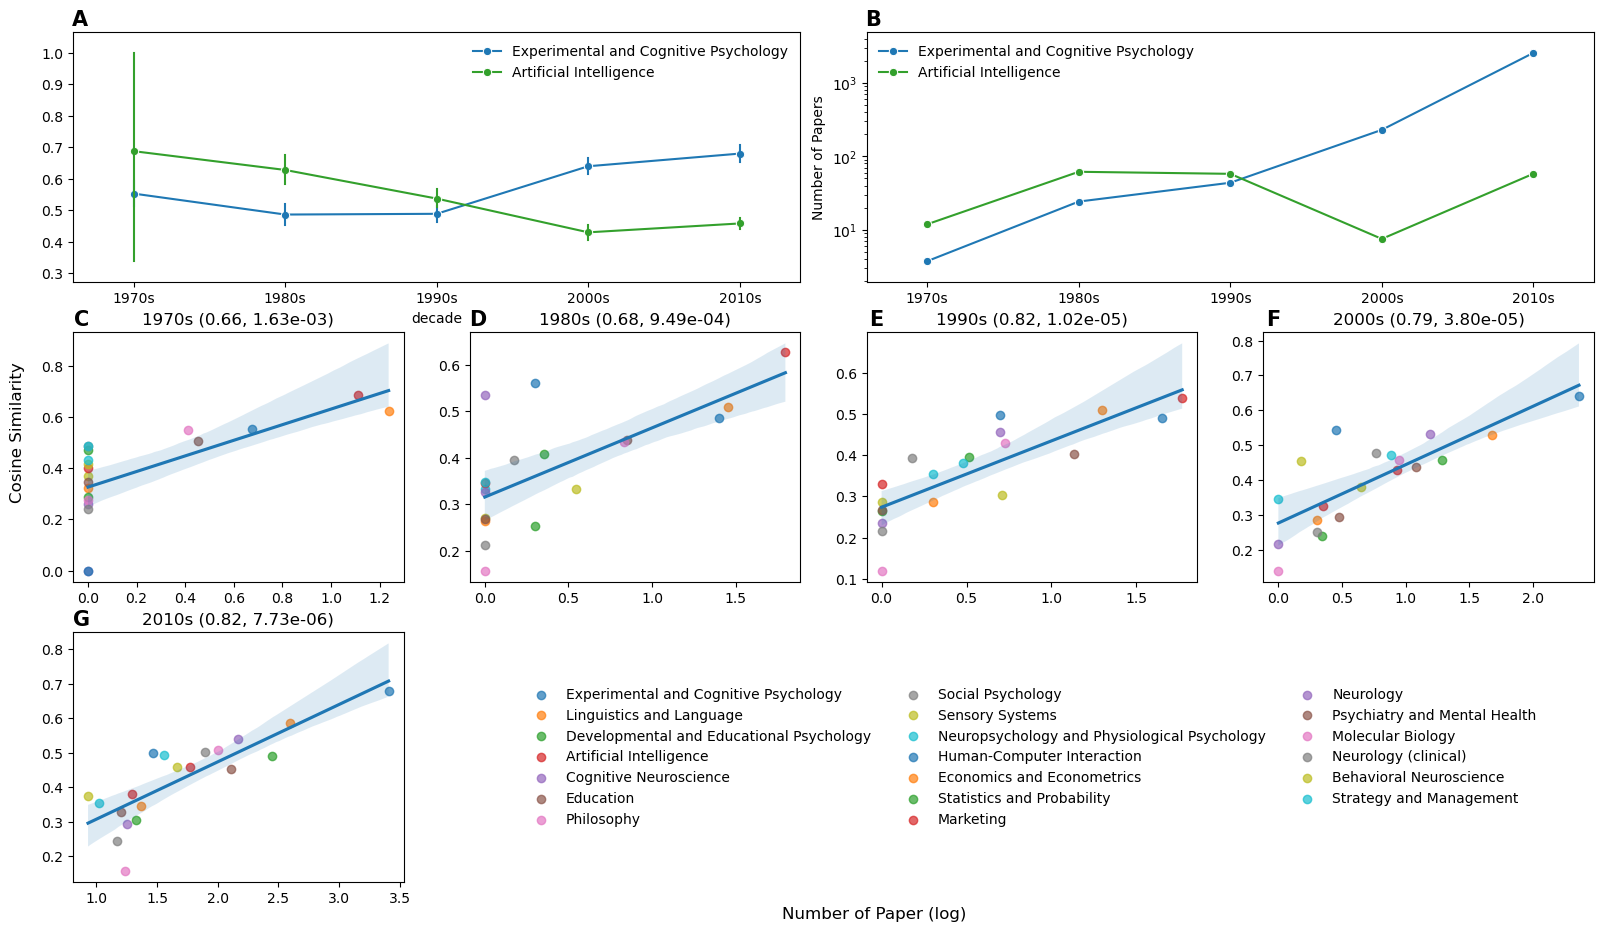

In [77]:
from scipy.stats import pearsonr
from matplotlib.gridspec import GridSpec

# 调整列顺序
count_df = count_df[disciplines]
cs_df = cs_df[disciplines]

# 用 0 填充缺失值
count_df = count_df.fillna(0)
cs_df = cs_df.fillna(0) 

# 获取所有年代的列表
decades = count_df.index.tolist()

# 创建一个 3x4 的 GridSpec 布局（3 行 4 列）
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(3, 4, figure=fig, wspace=0.2)

pannel_labels = list("ABCDEFGHI")
center_venue = 'Cognitve Science'

# 添加大图，跨越整个图形的前两列（3x4 的 GridSpec 布局中的第一个大区域）
ax_big_left = fig.add_subplot(gs[0, 0:2])
plt.margins(x=0.1, y=0.1)
melted_all_cs_df = pd.melt(all_cs_df[all_cs_df.subarea.isin(['Experimental and Cognitive Psychology', 
                                                             'Artificial Intelligence',
                                                             ])], id_vars=['VID', 'subarea', 'decade'], value_vars='similarity')
sns.lineplot(data=melted_all_cs_df, x='decade', y='value', hue='subarea', palette=color_dict, 
             err_style='bars', marker='o', dashes=False, ax=ax_big_left)
ax_big_left.set_ylabel('')
ax_big_left.legend(frameon=False)
# Plot pannel labels
ax_big_left.text(0.02, 1.09, pannel_labels[0], transform=ax_big_left.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# 添加大图，跨越整个图形的前两列（3x4 的 GridSpec 布局中的第二个大区域）
ax_big_right = fig.add_subplot(gs[0, 2:4])
sns.lineplot(count_df[['Experimental and Cognitive Psychology',
                       'Artificial Intelligence',]], 
             ax=ax_big_right, palette=color_dict, marker='o', dashes=False)
# 设置y轴为对数刻度
plt.yscale('log')
ax_big_right.set_ylabel('Number of Papers')
plt.margins(x=0.1, y=0.1)
handles, labels = ax_big_right.get_legend_handles_labels()
ax_big_right.legend(handles, labels, frameon=False)
# Plot pannel labels
ax_big_right.text(0.02, 1.09, pannel_labels[1], transform=ax_big_right.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# 为每个年代创建一个子图
for i, decade in enumerate(decades):

    ax = fig.add_subplot(gs[1 + i // 4, i % 4])
    # 分学科绘制散点图
    for discipline in disciplines:
        x = np.log10(count_df.loc[decade, discipline]+1) # 添加一个小的偏移量避免log(0)
        y = cs_df.loc[decade, discipline]
        ax.scatter(x, y, label=discipline, alpha=0.7)

    # 创建该年份的 count 和 similarity 数据
    x_vals = np.log10(count_df.loc[decade]+1) # 添加一个小的偏移量避免log(0)
    y_vals = cs_df.loc[decade]
    # 绘制回归线
    sns.regplot(x=x_vals, y=y_vals, ax=ax, scatter=False)
    # 计算皮尔逊相关系数
    corr_coef, p_value = pearsonr(x_vals, y_vals)
    # 设置子图标题，包含相关系数
    ax.set_title(f'{decade} ({corr_coef:.2f}, {p_value:.2e})')
    # 隐藏子图的 xlabel 和 ylabel
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Plot pannel labels
    ax.text(0.05, 1.09, pannel_labels[i+2], transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# 在第7幅子图的位置生成图例
legend_ax = fig.add_subplot(gs[-2])
legend_ax.axis('off')  # 隐藏坐标轴
handles, labels = ax.get_legend_handles_labels()
legend_ax.legend(handles, labels, loc='center', ncol=3, frameon=False)

fig.supxlabel('Number of Paper (log)')
fig.supylabel('Cosine Similarity')

fig.subplots_adjust(left=0.055, right=0.9, top=0.9, bottom=0.05, wspace=0.1, hspace=0.2)

plt.show()

In [78]:
fig.savefig('Cognitive_Science_corrleation.pdf',
            facecolor='white', 
            transparent=False,
            bbox_inches='tight')

Pearson correlation coefficient: 0.598
P-value: 4.979e-11


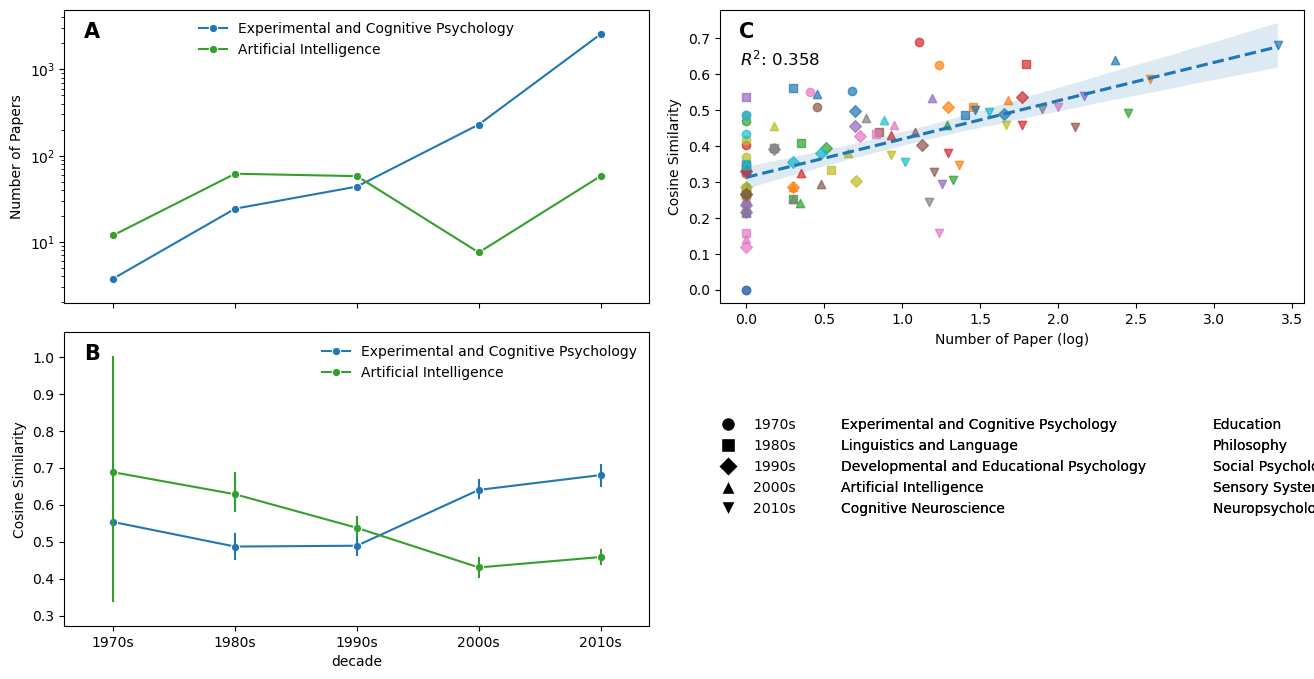

In [69]:
from scipy.stats import pearsonr

# 调整列顺序
count_df = count_df[disciplines]
cs_df = cs_df[disciplines]

count_df = count_df.fillna(0)
cs_df = cs_df.fillna(0)

decades = count_df.index.tolist() # get decades

pannel_labels = list("ABC")
fig = plt.figure(figsize=(16, 8))
##########################################
ax_1 = fig.add_subplot(2,2,1)
plt.margins(x=0.1, y=0.1)
sns.lineplot(count_df[['Experimental and Cognitive Psychology',
                       'Artificial Intelligence',]], 
             ax=ax_1, palette=color_dict, marker='o', dashes=False)
handles, labels = ax_1.get_legend_handles_labels()
ax_1.set_yscale('log')
ax_1.legend(handles, [label for label in labels], frameon=False)
ax_1.set_ylabel('Number of Papers')
ax_1.tick_params(labelbottom=False) # hide x-axis labels
# Plot pannel labels
ax_1.text(0.06, 0.96, pannel_labels[0], transform=ax_1.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')
##########################################
ax_2 = fig.add_subplot(2,2,3, sharex=ax_1)
plt.margins(x=0.1, y=0.1)
melted_all_cs_df = pd.melt(all_cs_df[all_cs_df.subarea.isin(['Experimental and Cognitive Psychology', 'Artificial Intelligence'])], id_vars=['VID', 'subarea', 'decade'], value_vars='similarity')
sns.lineplot(data=melted_all_cs_df, x='decade', y='value', hue='subarea', palette=color_dict, 
             err_style='bars', marker='o', dashes=False, ax=ax_2)
ax_2.set_ylabel('Cosine Similarity')
handles, labels = ax_2.get_legend_handles_labels()
ax_2.legend(handles, [label for label in labels], frameon=False)
ax_2.text(0.06, 0.96, pannel_labels[1], transform=ax_2.transAxes, fontsize=15, fontweight='bold', va='top', ha='right') # Plot pannel labels
##########################################
ax = fig.add_subplot(2,2,2)
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P']  # Different shapes for each decade
# Plot each discipline with different colors and each decade with different marker shapes
for i, (decade, marker) in enumerate(zip(decades, markers)):
    for j, discipline in enumerate(disciplines):
        x = count_df.loc[decade, discipline] + 1  # Log scale offset
        y = cs_df.loc[decade, discipline]
        ax.scatter(np.log10(x), y, label=discipline if i == 0 else "",
                   alpha=0.7, marker=marker)

# Prepare combined x and y values from all decades and disciplines
combined_x_vals = []
combined_y_vals = []
for decade in decades:
    x_vals = [count_df.loc[decade, discipline] + 1 for discipline in disciplines]  # Log scale offset
    y_vals = [cs_df.loc[decade, discipline] for discipline in disciplines]
    combined_x_vals.extend(np.log10(x_vals))  # log-transform x-values
    combined_y_vals.extend(y_vals)

# Using sns.regplot for the combined regression line
sns.regplot(x=combined_x_vals, y=combined_y_vals, scatter=False, ax=ax,
            line_kws={"linestyle": "--"})

ss_res = np.sum((combined_y_vals - np.polyval(np.polyfit(combined_x_vals, combined_y_vals, 1), combined_x_vals)) ** 2)
ss_tot = np.sum((combined_y_vals - np.mean(combined_y_vals)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
ax.text(0.035, 0.87, f"$R^2$: {r_squared:.3f}",
          transform=ax.transAxes, fontsize=12, verticalalignment='top',)

correlation_coef, p_value = pearsonr(combined_x_vals, combined_y_vals)
print(f"Pearson correlation coefficient: {correlation_coef:.3f}")
print(f"P-value: {p_value:.3e}")

# Create a separate legend for decades (first column)
decade_handles = [plt.Line2D([0], [0], marker=m, color='w', label=d, markerfacecolor='k', markersize=10)
                  for m, d in zip(markers, decades)]
# Create a separate legend for disciplines (remaining columns)
discipline_handles = [plt.Line2D([0], [0], marker='o', color='w', label=disc, markersize=10) for disc in disciplines]

legend_ax = fig.add_subplot(2,2,4)
legend_ax.axis('off')  # hide the axes for the legend axis
decade_legend = legend_ax.legend(handles=decade_handles, loc="upper left", bbox_to_anchor=(-0.03, 0.75), ncol=1, frameon=False)
discipline_legend = legend_ax.legend(handles=discipline_handles, 
                              loc="upper left", bbox_to_anchor=(0.12, 0.75), ncol=4, frameon=False)
# Add both legends to the plot
legend_ax.add_artist(decade_legend)
legend_ax.add_artist(discipline_legend)

# Label axes and show plot
ax.set_xlabel('Number of Paper (log)')
ax.set_ylabel('Cosine Similarity')
ax.text(0.06, 0.96, pannel_labels[2], transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

plt.subplots_adjust(wspace=0.12, hspace=0.1)
plt.show()

## Archive

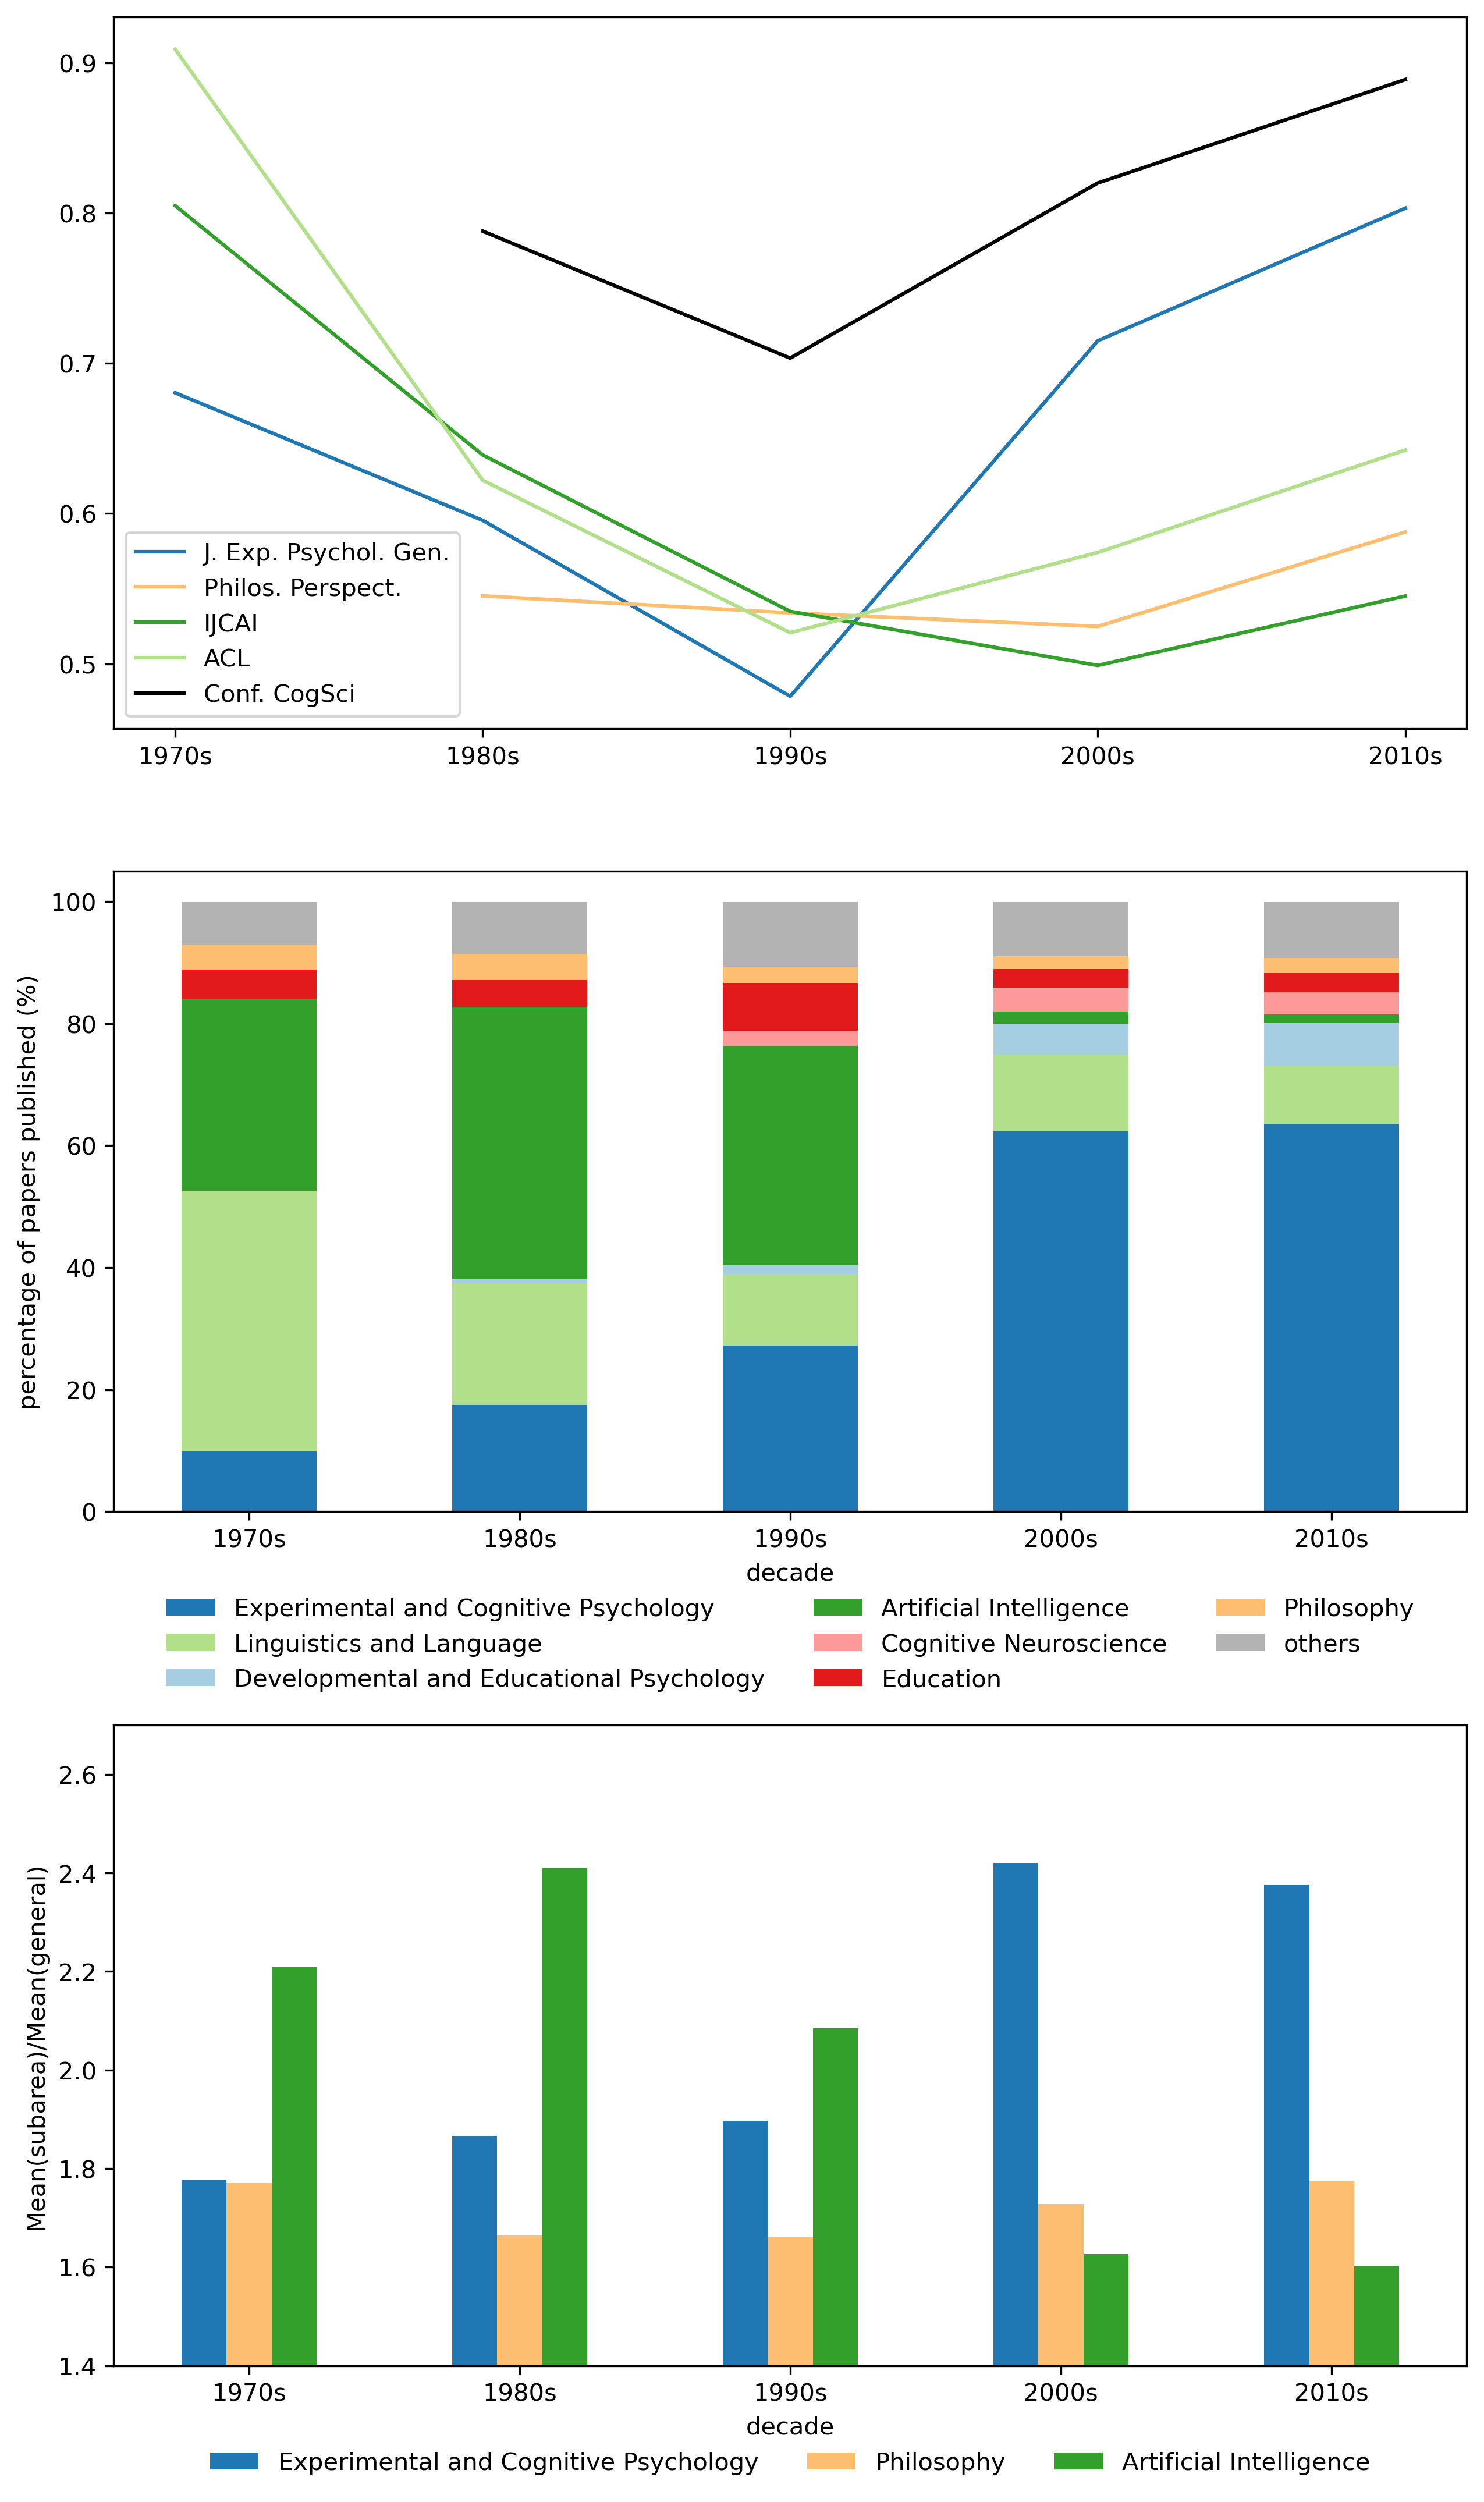

In [24]:
color_dict = {'Experimental and Cognitive Psychology': '#1f78b4', 
              'Linguistics and Language': '#b2df8a',	
              'Developmental and Educational Psychology': '#a6cee3',	
              'Artificial Intelligence': '#33a02c',	
              'Cognitive Neuroscience': '#fb9a99',
              'Education': '#e31a1c',	
              'Philosophy': '#fdbf6f',
              'others': '#b3b3b3'}

fig = plt.figure(figsize=(10,18), dpi=300)

plt.subplot(3,1,1)
jnl_color_dict = {
    'J. Exp. Psychol. Gen.': '#1f78b4',
    'Philos. Perspect.': '#fdbf6f',
    'IJCAI': '#33a02c',
    'ACL': '#b2df8a',
    'Conf. CogSci': '#000000',
}
jnl_abbr_dict = {
    'Journal of Experimental Psychology: General': 'J. Exp. Psychol. Gen.',
    'Philosophical Perspectives': 'Philos. Perspect.',
    'international joint conference on artificial intelligence': 'IJCAI',
    'meeting of the association for computational linguistics': 'ACL',
    'conference cognitive science': 'Conf. CogSci',
}
jnl_cs_df.rename(columns=jnl_abbr_dict, inplace=True)
sns.lineplot(jnl_cs_df, palette=jnl_color_dict, dashes=False)

plt.subplot(3,1,2)
ax = count_df.plot(kind ='bar', stacked = True, ax=plt.gca(),
                   xlabel='decade', ylabel='percentage of papers published (%)', rot=0,
                   color=color_dict)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          edgecolor='white', ncol=3)

plt.subplot(3,1,3)
ax_cs = cs_df[['Experimental and Cognitive Psychology',
               'Philosophy', 
               'Artificial Intelligence']].plot(kind ='bar', ax=plt.gca(), 
                                                xlabel='decade', ylabel='Mean(subarea)/Mean(general)', rot=0,
                                                color=color_dict)
ax_cs.set_ylim(1.4, 2.7)
box = ax_cs.get_position()
ax_cs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax_cs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
             edgecolor='white', ncol=3)

plt.show()

In [26]:
fig.savefig('Cognitive Science.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False)